## Part 1: NYC taxi data

### Basic Questions

Note: all the answers here are based on a random 6,000-record sample I used to make this analysis quick on my laptop (under 2 minutes, to give you an idea). However, the codes have been verified to work with the full data or much larger samples. Naturally, a run on the full data will take considerably longer. You can run on any sample you want by specifying the sample_n argument for the method  *get_and_process_data*, for example

> .get_and_process_data(sample_n=100000)

1. What is the distribution of number of passengers per trip?
    - A single passenger in a cab is the most typical. Run the codes to see all details.
2. What is the distribution of payment_type? 
    - It's overwhelmingly credit cards or cash. What's more interesting though is that credit cards have overtaken cash already. Run the codes for more.
3. What is the distribution of fare amount? 
    - 6.50 is the most common fare closely followed by 7.0. Run the codes to get the full picture.
4. What is the distribution of tip amount? 
    - Tips are usually 1 dollar if not 0 (which may also mean an unreported tip). More on this below.
5. What is the distribution of total amount?
    - Most frequently people paid 9.50. Full distributions are produces by the codes below.
6. What are top 5 busiest hours of the day? 
    - A preview: yes, sometime after work (6 pm) is the busiest. Run the codes to find out more.
7. What are the top 10 busiest locations of the city?
    - The 8th, 7th Avenues, airports.. Run the codes for more. 
8. Which trip has the highest standard deviation of travel time?
    - Answer to this one varies a lot depending on the random sample. For example, last time I got an odd trip at Lincoln Tunnel access - probably due to a good change to get stuck in traffic around there.
9. Which trip has most consistent fares?
    - Similar considerations to question 8. Last time I got West 27th Street -> 8th Avenue. Run the code to see what you get.

### Open Questions

1. In what trips can you confidently use respective means as measures of central tendency
to estimate fare, time taken, etc.

    - Suppose it's about the fare. When we say "confidently use" we mean that knowing the mean fare should give us a resonably accurate sense of what this fare should be typically. Knowing what fare to expect helps make "right" decisions such as "ok, I'm happy to pay about 10 usd to get to Brooklyn". Or maybe "it's 10 bucks which i think is too much, i'm catching metro for 2.50". We'd use the means for the trips which cost roughly the same over the recorded 30 days, i.e. there were no clearly unusual charges ("outliers"). The reason is that outliers can strongly affect means. For example, let's say the fares for a trip recorded 10 times were about 1 dollar 9 times and then suddenly 20 dollars. The mean would be (9*1+20)/10=2.90 which is almost triple the typical ~1 dollar fare. Instead of means we'd use measures unaffected by extreme values, e.g. median which would be 1 dollar in this example - clearly, a much more accurate estimation.
    
2. Can we build a model to predict fare and tip amount given pick up and drop off
coordinates, time of day and week?

    - Of course. One of the simplest and yet completely usable models would be the one showing you some of measures mentioned in question 1. For example, we can put together a model that (based on the data we have) calculates median tip and mean fare for any  pair of the pickup and dropoff locations by time of day and week. Should these measures be accurate enough estimates (as discussed in question 1), we have a cheap and accurate for our purposes model on our hands. What if some pair of locations is not in the data? Then we introduce a straightforward extension: the model will now find the nearest locations for which the fare and tip amounts are avaiable, calculate the measures and produce these as the best estimates. To take this a notch higher, we can build a regression model that takes locations, time of day and week as variables.
    
3. If you were a taxi owner, how would you maximize your earnings in a day?

    - While there would be multiple strategies to do this, we could stick with a "greedy" approach, i.e. maximising the earnings as we go. That is, once a trip is completed all we think about is how to make the next trip most profitable and don't care about more complex strategies that may involve giving up lucrative rides one time only to earn more another time. A straightforward approach to earning as much as possible would be then to do as many rides as possible. Which in turn would suggest heading to the nearest area where the highest demand is at a particular time. On a higher level, this can be framed as an optimisation problem when there's a function (we can call it a "profit function" in this case) describing earnings depending on the things  (variables) perceived important. For example, distance to the pickup spot, likely gas spend, trip distance, etc. We then figure out the values of these variables which will make the function spit out the highest value (profit).
    
4. If you were a taxi owner, how would you minimize your work time while retaining the
average wages earned by a typical taxi in the dataset?

    - This is a setup for another optimisation problem similar to the one mentioned in the previous question. The difference would be in the function we would care about. Specifically, the function would produce the work time depending on the factors potentially affecting this time (all of the available data points may have an effect, direct or indirect). Our goal would be to minimise the value the function produces. However, we also want to make sure the average wages are not getting worse. To ensure that, we put together another function that produces average wages when given all important inputs the wages are likely to depend on. This function must return either exactly the existing average wages (if we decide to stick to retain, literally) or higher wages which we might like even better. The former leads to a problem of minimising the work time under an equality constrain (we will only accept the inputs making the time function minimal if these don't stand in the way of the average wages function producing the exact same amount as now) while the latter involves an inequality constrain (the average wages need to be >= the current ones).
    
    
5. If you run a taxi company with 10 taxis, how would you maximize your earnings?

    - Having 10 taxis changes the perspective a bit. Now we can pay more attention to positioning each car in an optimal way which is not necessarily to be in the right time and place to get the biggest profit per car, especially if we start accounting for the competitors activities (what if some of our cars are also contributing to creating additional profit opportunities by interfering with the competitots plans?). Compared to question 3, now it's like you can have you cab in 10 different places if you wish. As for the strategies for each individual car, one option would be to once again do the "greedy" moves. But how exactly can we formalise all this as an optmisation problem?
    
    For instance, in a paper called  [Optimization of the Revenue of the New York City Taxi Service
using Markov Decision Processes](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwjr38XU7eviAhVUSX0KHW1uA6EQFjAAegQIAhAC&url=https%3A%2F%2Fwww.thinkmind.org%2Fdownload.php%3Farticleid%3Ddata_analytics_2017_4_10_68005&usg=AOvVaw20xI__XMp6SKzHjUGRb70T) they present a metodology based on the Markov Decision Process approach. It's easy to apply to the Manhattan grid-like streets and involves a choice of 9 moves for a cab drives to decide on,  

    > 7 8 9
    
    > 4 5 6
    
    > 1 2 3

    where 4 means a move to the nearest *west* location, *2* is for the southern location, 9 is for the north-eastern, etc.
    
    Another interesting approach is to make use of the reinforcement learning framework as described here: [Optimize taxi driving strategies based on reinforcement learning](https://www.tandfonline.com/doi/abs/10.1080/13658816.2018.1458984)

## Part 2: Open showcase
After the presentation of you results for “NYC taxi data” case, you’ll have the opportunity to present your
own work for 15 minutes.
Please illustrate with an achievement of your choice (e.g. publication, participation in the community,
portfolio, open repository, etc).

- Introducing my Python package called mta that contains implementations of many Multi-Touch Attribution models. See the slides or better
> pip3 install mta

(docs: https://github.com/eeghor/mta)

### Available Data

**Note**: many column names begin with a white space!

The **trip**-related data points are the following:

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' rate_code',
* ' store_and_fwd_flag',
* ' pickup_datetime',
* ' dropoff_datetime',
* ' passenger_count',
* ' trip_time_in_secs',
* ' trip_distance',
* ' pickup_longitude',
* ' pickup_latitude',
* ' dropoff_longitude',
* ' dropoff_latitude'

and the **fare** CSV file contains the columns as below

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' pickup_datetime',
* ' payment_type',
* ' fare_amount',
* ' surcharge',
* ' mta_tax',
* ' tip_amount',
* ' tolls_amount',
* ' total_amount'

In [54]:
import pandas as pd
import re
import seaborn as sns
import arrow
import time
from collections import Counter, defaultdict, namedtuple
import geopandas as gpd
import numpy as np
from geopy.geocoders import Nominatim

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(12,6)})

nom = Nominatim(user_agent='app', timeout=10)

In [55]:
class Taxi:
    
    """
    returns answers to all Basic Questions as a dictionary
    
    sample output:
    
    defaultdict(None,
            {'trip_w_most_consistent_fares': {'trip': {'coords': '(40.733, -73.987)->(40.747, -73.977)',
               'from_to': '(3rd Avenue)->(East 36th Street)'},
              'fares': [6.5, 6.5]},
             'passengers_per_trip': Counter({'1': 4278,
                      '3': 230,
                      '2': 782,
                      '5': 358,
                      '4': 118,
                      '6': 234}),
             'payment_types': Counter({'CRD': 160291,
                      'CSH': 132520,
                      'UNK': 192,
                      'NOC': 216,
                      'DIS': 94}),
             'busiest_locations': [('(40.75, -73.991)', '7th Avenue', 30),
              ('(40.751, -73.991)', 'West 34th Street', 18),
              ('(40.75, -73.995)', '8th Avenue', 17),
              ('(40.749, -73.992)', '7th Avenue', 16),
              ('(40.75, -73.992)',
               'Two Penn Plaza, 2, Tracks 11/12, Chelsea, Manhattan Community Board 4, Manhattan, New York County, NYC, New York, 10121, USA',
               13)],
             'trip_w_highest_std_traveltime': {'coords': '(40.769, -73.863)->(40.757, -73.993)',
              'from_to': '(East Elmhurst, Queens, Queens County, NYC, New York, 11369, USA)->(8th Avenue)'},
             'busiest_hrs': [(19, 767),
              (20, 712),
              (21, 711),
              (18, 665),
              (22, 643)],
              'fare_amounts': Counter({'15': 4175,
                      '9.5': 11507,
                      '17': 2955,
                      '11': 8757,
                      '8': 13819,
                      '4': 7060,
                      '15.5': 3856,...}),
             'tip_amounts': Counter({'0': 140517,
                      '2': 14751,
                      '2.12': 824,
                      '1': 27279,
                      '3.3': 1163,
                      '10.4': 1009,
                      '1.9': 3249,...}),
            'total_amounts': Counter({'16': 2891,
                      '12.5': 7810,
                      '18': 2542,
                      '12': 6175,
                      '11.12': 802,
                      '11.5': 5856,
                      '5': 5065,
                      '20.3': 799,...})
              
    """
    
    def __init__(self, trip_file, fare_file):
        
        Location = namedtuple('Location', 'lat lng')
        
        self.EMP_STATE_BUILDING = Location(lat=40.7484, lng=-73.9856)
        
        self.ANSWERS = defaultdict()
        
        self.FILES = {'trips': 'data/' + trip_file,
                     'fares': 'data/' + fare_file}
        
        self.COLS = {'latitude': [' pickup_latitude', ' dropoff_latitude'],
                     'longitude': [' pickup_longitude', ' dropoff_longitude'],
                     'useless': [' vendor_id', ' rate_code', ' store_and_fwd_flag', 
                                 ' hack_license', ' vendor_id', ' tolls_amount',
                                 ' mta_tax', ' surcharge']}
        
    def fix_coords(self, c, lat_lng):
        
        """
        returns the original longitude or latitude rounded to 3 decimal digits if their values are not too far
        from the Empire State Building; otherwise returns None
        
        we are being very generous here weeding out only the most remote locations (0 decimal places 
        i.e. something like 100km away) - 
        see https://en.wikipedia.org/wiki/Decimal_degrees
        
        important! we do the coordinate rounding because when it comes to discussing trips or locations, 
        the street-level accuracy appears to be more practically useful, e.g. 
        "how much is it normally from Windmill St to Market St?" is more useful to know than an answer to
        "what is the typical fare from 30 Windmill St to 241 Market St"?
        """
        
        c_ = 'lng' if lat_lng == 'longitude' else 'lat' if lat_lng == 'latitude' else None
        
        if not c_:
            raise Exception(f'{self.fix_coords.__name__}: argument lat_lng is neither latitude nor longitude!')
            
        try:
            return round(float(c),3) if abs(float(c) - getattr(self.EMP_STATE_BUILDING, c_)) < 1 else None
        except:
            pass
        
    def get_and_process_data(self, show_counts=False, sample_n=None):
        
        """
        load the data; pick a random sample to use if needed; get rid of the columns we won't ever use 
        to answer the questions
        """
        
        self.trips = pd.read_csv(self.FILES['trips'], dtype=str)
        self.trips = self.trips.drop([c for c in self.trips.columns if c in self.COLS['useless']], axis=1)
        
        if sample_n:
            self.trips = self.trips.sample(n=sample_n)
        
        self.fares = pd.read_csv(self.FILES['fares'], dtype=str)
        self.fares = self.fares.drop([c for c in self.fares.columns if c in self.COLS['useless']], axis=1)
        
        if sample_n:
            self.fares = self.fares[self.fares['medallion'].isin(self.trips['medallion']) & 
                                   self.fares[' pickup_datetime'].isin(self.trips[' pickup_datetime'])]
        
        if show_counts:
            
            print(f'cabs: {self.trips["medallion"].nunique():,}')
            print(f'drivers: {self.trips[" hack_license"].nunique():,}')
            # note that the date format is 2013-04-04 18:47:45
            print(f'days: {self.trips[" pickup_datetime"].apply(lambda x: arrow.get(str(x), "YYYY-MM-DD")).nunique():,}')   
        
        for col_lst in 'longitude latitude'.split():
                  self.trips[self.COLS[col_lst]] = self.trips[self.COLS[col_lst]] \
                                                          .applymap(lambda x: self.fix_coords(c=x, lat_lng=col_lst))
        
        for s in 'pickup dropoff'.split():
                  
            avail_mask = self.trips[f' {s}_longitude'].notnull() & self.trips[f' {s}_latitude'].notnull()
            self.trips[f'{s}_loc'] = '(' + self.trips[f' {s}_latitude'].astype(str) + ', ' + self.trips[f' {s}_longitude'].astype(str) + ')'
            self.trips[f'{s}_loc'] = self.trips[f'{s}_loc'].where(avail_mask, None)
                  
        self.trips['trip_'] = self.trips['pickup_loc'] + '->' + self.trips['dropoff_loc']
                  
        self.trips = self.trips.drop(self.COLS['latitude'] + self.COLS['longitude'], axis=1)
        
        return self
                  
    def get_passengers_per_trip(self):
        
        """
        returns a dictionary maps the number of passengeers to trip counts    
        """
                  
        # how do we define a trip in this case? "a cab with numberplate XXXX picked someone up at time TTTT" - that's a trip
        # this defines a trip in a unique way if we reasonably sssume that a specific cab can't do multiple pickupos at
        # the same time - if we do see that happening it's probably due to an error in data
                  
        TRIP_ID = ['medallion', ' pickup_datetime']
                  
        self.ANSWERS['passengers_per_trip'] = Counter(self.trips[TRIP_ID + [' passenger_count']] \
                                                              .drop_duplicates(TRIP_ID) \
                                                              .groupby(TRIP_ID) \
                                                              .sum()[' passenger_count'])
        return self
                  
    def get_payment_types(self):
        
        """
        returns a dictionary maps payment types to record counts    
        """
                  
        TRIP_ID = ['medallion', ' pickup_datetime']
                  
        self.ANSWERS['payment_types'] = Counter(self.fares.drop_duplicates(TRIP_ID)[' payment_type'] \
                                                              .tolist())
        return self
                  
    def get_busiest_hours(self, hrs=5, dropoffs=True):
                  
        """
        return the top hrs busiest hours
        
        what is "busiest"? let's say it's when we see the most pickups or dropoffs; we could just stick to 
        pickups as that would reflect both the drivers and clients perspective. 
        However, dropoffs could matter to non-taxi drivers (traffic jams).
        Hence add an option to pick either pickups or both pickups and dropoffs.
        
        """
        
        relevant_hours = self.trips[' pickup_datetime'].dropna().apply(lambda x: arrow.get(x).hour).tolist()
        
        if dropoffs:
                  relevant_hours += self.trips[' dropoff_datetime'].dropna().apply(lambda x: arrow.get(x).hour).tolist()
                  
        self.ANSWERS['busiest_hrs'] = Counter(relevant_hours).most_common(hrs)
                  
        return self
                  
    def get_busiest_locations(self, n=5):
                  
        """
        return top n busiest location
        """
                  
        # busiest locations will be those where there are most pickups and/or dropoffs 

        self.ANSWERS['busiest_locations'] = [(loc, self.coords_to_street(loc), count) for loc, count in sorted([(k, v) for k,v in 
                                                    {**Counter(self.trips['pickup_loc'].dropna()), 
                                                     **Counter(self.trips['dropoff_loc'].dropna())}.items()], 
                                                       key=lambda x: x[1], reverse=True)[:n]]
        return self
                  
    def get_most_unpredictable_trip(self):
                  
        """
        return a trip with the most varying (highest standard deviation) travel time
        """
                  
        ss = self.trips[['trip_', ' trip_time_in_secs']].dropna(subset=['trip_'])
        ss[' trip_time_in_secs'] = ss[' trip_time_in_secs'].astype(float)
                  
        ind = ss.groupby(['trip_']).std(ddof=0).idxmax().tolist()[0]
                  
        self.ANSWERS['trip_w_highest_std_traveltime'] = {'coords': ind,
                                                            'from_to': '->'.join(['(' + self.coords_to_street(loc) + ')' 
                                                                                       for loc in ind.split('->')])}
                  
        return self
    
    def coords_to_street(self, coord):
                  
        """
        returns a street level description given location coordinates
        """
        coord = re.sub(r'[\(\)\[\]\s]+','', str(coord))
        
        try:
            res = nom.reverse(coord)
        except:
            print(f'can\'t figure out address for location ({coord})!')
            return None
                  
        if res.raw['address'].get('road', None):
            return res.raw['address']['road']
        else:
            return res.address
        
    
    def get_payment_breakdown_distros(self):
        
        """
        returns a dictionary that maps 
        
            fare amount
            tip amount
            total amount
            
        to payment counts

        """
                  
        # we don't need all columns here, just these:
        cols = [' fare_amount', ' tip_amount', ' total_amount']
        
        for c in cols:
            self.ANSWERS[c.strip() + 's'] = Counter(self.fares[c].dropna())
        
        return self
    
    def get_most_consistent_trip(self):
                  
        """
        which trip has 'most consistent fares'? Firstly, what is a trip here? - it's a pair of locations (pickup -> dropoff);
        for each of such trips we'd like to find ot how much the fares vary and then select the trip with the least varying fare
        """
        
        g = self.trips[['medallion', ' pickup_datetime', 'trip_']] \
                  .join(self.fares[['medallion', ' pickup_datetime', ' total_amount']] \
                        .set_index(['medallion', ' pickup_datetime']),
                                        on=['medallion', ' pickup_datetime'], how='inner').reset_index()[['trip_', ' total_amount']]
        
        print(f'unique trips with fares: {g["trip_"].nunique():,}')
        
        g[' total_amount'] = g[' total_amount'].astype(float)
        
        # get the counts of trips; it makes more sense to look into fare variability for the trips done more than once
        cs = g.groupby(['trip_']).count()
                  
        tps = set(cs[cs[' total_amount'] > 1].reset_index()['trip_'])
        
        print(f'trips done more than once: {len(tps):,}')
        
        fare_stds = g[g['trip_'].isin(tps)].groupby('trip_').std()
        t = fare_stds[' total_amount'].idxmin()
        t_fares = g[g['trip_'] == t][' total_amount'].tolist()
              
        self.ANSWERS['trip_w_most_consistent_fares'] = {'trip': {'coords': t,
                                                                 'from_to': '->'.join(['(' + self.coords_to_street(loc) + ')' 
                                                                                       for loc in t.split('->')])},
                                                        'fares': t_fares}
              
        return self  

In [56]:
if __name__ == '__main__':
    
    t0 = time.time()
    tx = Taxi(trip_file='trip_data_4.csv', fare_file='trip_fare_4.csv') \
                        .get_and_process_data(sample_n=6000) \
                        .get_most_consistent_trip() \
                        .get_passengers_per_trip() \
                        .get_payment_types() \
                        .get_busiest_locations() \
                        .get_most_unpredictable_trip() \
                        .get_busiest_hours() \
                        .get_payment_breakdown_distros()
                            
    t1 = time.time()
    m, s = divmod(t1-t0, 60)
    print(f'elapsed time: {m:.0f} m {s:.0f} s')

unique trips with fares: 5,868
trips done more than once: 11
Index(['medallion', ' pickup_datetime', ' payment_type', ' fare_amount',
       ' tip_amount', ' total_amount'],
      dtype='object')
elapsed time: 1 m 50 s


#### Answers

In [66]:
# uncomment and run; why is it commented out? because of a large output. you'll see what i mean
# tx.ANSWERS

#### Passengers per Trip

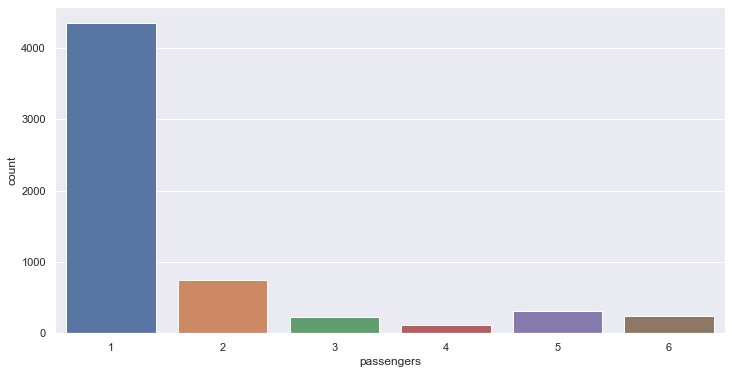

In [57]:
sns.barplot(data=pd.DataFrame.from_dict(tx.ANSWERS['passengers_per_trip'], orient='index') \
            .reset_index().rename(columns={'index':'passengers', 0: 'count'}), x='passengers', y='count')

#### Busiest Hours

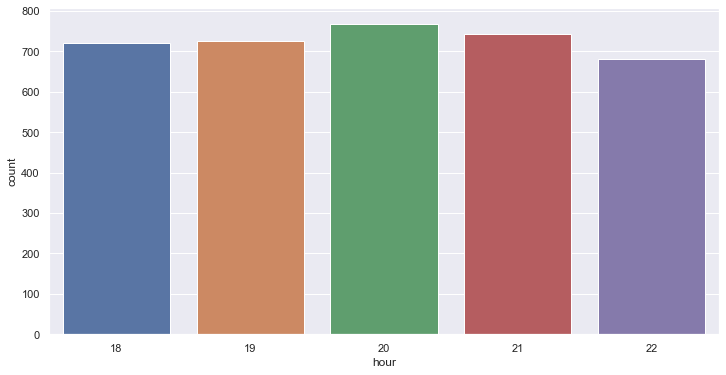

In [58]:
sns.barplot(data=pd.DataFrame.from_records(tx.ANSWERS['busiest_hrs']) \
            .rename(columns={0: 'hour', 1: 'count'}), x='hour', y='count')

#### Payment Types

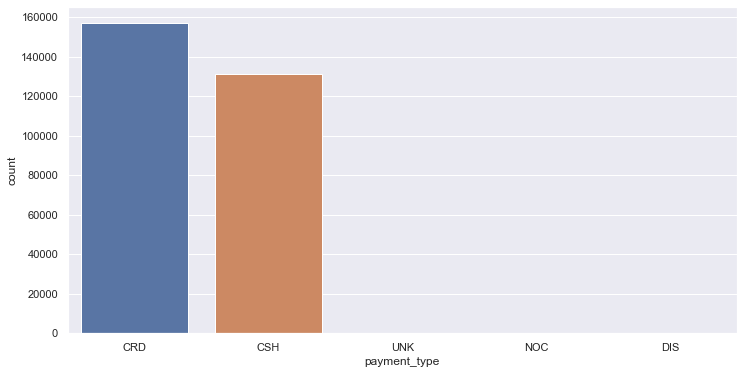

In [59]:
sns.barplot(data=pd.DataFrame.from_dict(tx.ANSWERS['payment_types'], orient='index') \
            .reset_index().rename(columns={'index':'payment_type', 0: 'count'}),
x='payment_type', y='count')

#### Tips

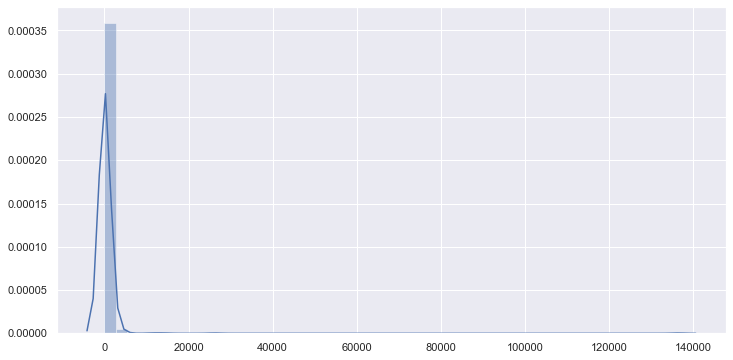

In [60]:
sns.distplot(sorted(tx.ANSWERS['tip_amounts'].values()))

Some \\$100,000+ tips here. Interesting if true. What if we take a closer look at the more typical ones like \\$10 or under:

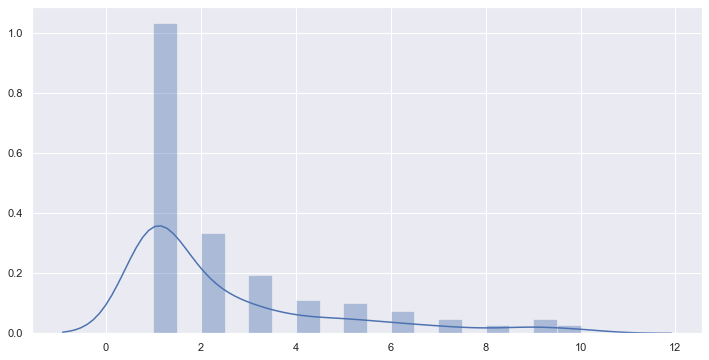

In [61]:
sns.distplot([v for v in sorted(tx.ANSWERS['tip_amounts'].values()) if v <=10])

#### Fares

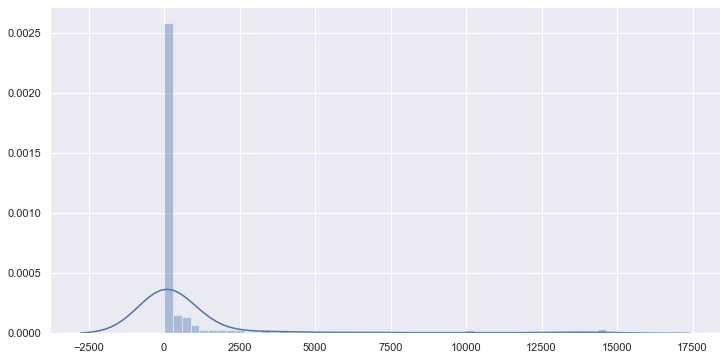

In [62]:
sns.distplot(sorted(tx.ANSWERS['fare_amounts'].values()))

Like with tips, let's look at the popular ones:

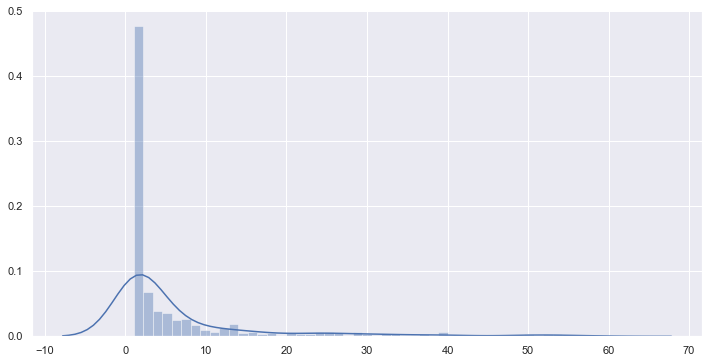

In [63]:
sns.distplot([v for v in sorted(tx.ANSWERS['tip_amounts'].values()) if v <=60])

#### Totals

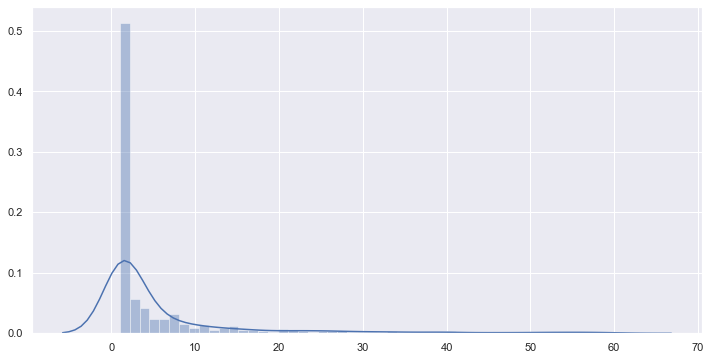

In [64]:
sns.distplot([v for v in sorted(tx.ANSWERS['total_amounts'].values()) if v <=60])